# Ứng dụng mạng Neural trong Classification

## Import một số thư viện cần thiết

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import pylab
import time
import matplotlib.text as plttext
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
%matplotlib inline
# %matplotlib notebook

## Hàm tạo data

In [24]:
# Create 2D dataset with 3 label

# Random
rng = np.random.RandomState(1311)

def create_data(num_sample=None):
    """
    Generate samples of 3 classes using normal distribution
    + type(num_sample) int
    + param num_sample: number of sample to be generated for each class
    + return: data and label for each class
    """
    I = np.eye(3, dtype=np.float32)
    
    if(num_sample == None):
        num_sample = 100
        
    # Generate first class
    m1 = np.asarray([0, 0], dtype=np.float32)
    cov1 = np.asarray([[0.5, 0], [0, 0.5]], dtype=np.float32)
    data1 = rng.multivariate_normal(m1, cov1, num_sample)
    label1 = np.ones((num_sample), dtype=np.uint16) - 1
    label1 = I[label1,:]
    
    # Generate second class
    m2 = np.asarray([5,5], dtype=np.float32)
    cov2 = np.asarray([[0.5, 0], [0, 0.5]], dtype=np.float32)
    data2 = rng.multivariate_normal(m2, cov2, num_sample)
    label2 = np.ones((num_sample), dtype=np.uint16)
    label2 = I[label2, :]
    
    # Generate third class
    noise = np.abs((np.reshape(rng.normal(0, 0.01, num_sample), (num_sample,1))))
    S1 = np.asarray([[1, 0], [0, 0.7]], dtype=np.float32)
    S2 = np.asarray([[4, 0], [0, 4]], dtype=np.float32)
    m3 = np.asarray([0.5, 0.5], dtype=np.float32)
    cov3 = np.asarray([[0.5, 0], [0, 0.5]], dtype=np.float32)
    data3 = rng.multivariate_normal(m3, cov3, num_sample)
    data3 = data3/np.repeat(np.sqrt(np.sum(data3**2, 1, keepdims=True) + noise), 2, 1)
    data3 = np.dot(S2, np.dot(S1, data3.T)).T
    
    d = np.sqrt(np.sum(data3**2, 1, keepdims=True))
    d1 = np.reshape(d<2.5, (num_sample))
    data3[np.ix_(d1, [True, True])] = data3[np.ix_(d1, [True, True])]/np.repeat(d[d1], 2, 1)

    label3 = np.ones((num_sample), dtype=np.uint16) + 1
    label3 = I[label3, :]

    return (data1, label1, data2, label2, data3, label3)

## Hàm chia tập dataset để Train, Test và Validation

In [25]:
def devideDataset(data1, label1, data2, label2, data3, label3, numOfTrain, numOfValidation):
    train_X = np.concatenate((data1[0:numOfTrain, :],
                              data2[0:numOfTrain, :],
                              data3[0:numOfTrain, :]))

    train_Y = np.concatenate((label1[0:numOfTrain, :],
                              label2[0:numOfTrain, :],
                              label3[0:numOfTrain, :]))

    val_X = np.concatenate((data1[numOfTrain:(numOfTrain + numOfValidation), :],
                              data2[numOfTrain:(numOfTrain + numOfValidation), :],
                              data3[numOfTrain:(numOfTrain + numOfValidation), :]))

    val_Y = np.concatenate((label1[numOfTrain:(numOfTrain + numOfValidation), :],
                              label2[numOfTrain:(numOfTrain + numOfValidation), :],
                              label3[numOfTrain:(numOfTrain + numOfValidation), :]))

    test_X = np.concatenate((data1[(numOfTrain + numOfValidation):, :],
                            data2[(numOfTrain + numOfValidation):, :],
                            data3[(numOfTrain + numOfValidation):, :]))

    test_Y = np.concatenate((label1[(numOfTrain + numOfValidation):, :],
                            label2[(numOfTrain + numOfValidation):, :],
                            label3[(numOfTrain + numOfValidation):, :]))

    return (train_X, train_Y, val_X, val_Y, test_X, test_Y)

## Visualize dataset

In [26]:
def visualize_data(data1, data2, data3, figure_num):
    if(data1.shape[0] > 1000):
        sizeOfPoint = 10
    else:
        sizeOfPoint = 50
    
    plt.figure(figure_num)
    plt.axis('equal')
    plt.scatter(data1[:,0], data1[:,1], sizeOfPoint, 'r', label='class_red')
    plt.scatter(data2[:, 0], data2[:, 1], sizeOfPoint, 'g', label='class_green')
    plt.scatter(data3[:, 0], data3[:, 1], sizeOfPoint, 'b', label='class_blue')
    plt.xlabel('$x$', fontsize=15)
    plt.ylabel('$y$', fontsize=15)
    plt.grid()
    plt.legend(loc=3)
    plt.show()
    
def find_decision_boundary(X, Y, W1, b1, W2, b2, config):
    num_fake_data = 150
    num_train_sample = X.shape[0]
    num_feature = X.shape[1]
    num_hidden_node = W1.shape[1]
    num_class = Y.shape[1]

    demo_type = config['demo_type']
    activation_function_type = config['activation_function']
    min_X1 = np.min(X[:, 0]) - 0.1
    max_X1 = np.max(X[:, 0]) + 0.1
    min_X2 = np.min(X[:, 1]) - 0.1
    max_X2 = np.max(X[:, 1]) + 0.1

    # Create grid data
    X1 = np.linspace(min_X1, max_X1, num_fake_data)
    X2 = np.linspace(min_X2, max_X2, num_fake_data)
    xv, yv = np.meshgrid(X1, X2)
    xv = xv.flatten().astype(np.float32).reshape((num_fake_data ** 2, 1))
    yv = yv.flatten().astype(np.float32).reshape((num_fake_data ** 2, 1))
    X = np.concatenate((xv, yv), 1)

    del xv
    del yv

    a1 = np.dot(X, W1) + b1
    z1 = activation_function(a1, activation_function_type)
    a2 = np.dot(z1, W2) + b2
    # pred = np.repeat(np.argmax(a2, 1).reshape((num_fake_data**2, 1)), 2, 1)
    pred = np.argmax(a2, 1)
    grid0 = X[pred == 0, :]
    grid1 = X[pred == 1, :]
    grid2 = X[pred == 2, :]

    grid0 = grid0.reshape((grid0.shape[0], num_feature))
    grid1 = grid1.reshape((grid1.shape[0], num_feature))
    grid2 = grid2.reshape((grid2.shape[0], num_feature))

    return (grid0, grid1, grid2)


def visualize_decision_grid(data1, data2, data3, figure_num):
    plt.figure(figure_num)
    plt.axis('equal')
    plt.scatter(data1[:, 0], data1[:, 1], 10, c=[1, 0.5, 0.5], marker='+')
    plt.scatter(data2[:, 0], data2[:, 1], 10, c=[0.5, 1, 0.5], marker='+')
    plt.scatter(data3[:, 0], data3[:, 1], 10, c=[0.5, 0.5, 1], marker='+')
    bp = 1
    
def train_draw(X, Y, W1, b1, W2, b2, config, all_cost, i, J):
    # Display the training process

    num_hidden_node = config['num_hidden_node']
    num_train_per_class = config['num_train_per_class']
    train_method = config['train_method']
    save_img = config['save_img']
    demo_type = config['demo_type']

    lr = config['lr']

    pylab.clf()
    f = plt.figure(2, figsize=(10, 5))
#     f = plt.figure(2, figsize=(12, 6))
#     f = plt.figure(2)

    title = '%s with %d hidden nodes, lr = %.4g, %d epoch, cost = %.4g' % (train_method, num_hidden_node, lr, i, J)

    plt.subplot(1, 2, 1)
    [grid1, grid2, grid3] = find_decision_boundary(X, Y, W1, b1, W2, b2, config)

    visualize_decision_grid(grid1, grid2, grid3, 2)

    visualize_data(X[0:num_train_per_class, :],
                   X[num_train_per_class:num_train_per_class * 2, :],
                   X[num_train_per_class * 2:, :], 2)
    plt.subplot(1, 2, 2)
    plt.plot(all_cost, 'b')
    plt.xlabel('Iter')
    plt.ylabel('Cost')

    f.suptitle(title, fontsize=15)
    plt.pause(0.1)

    pylab.draw()

## Các hàm sử dụng huấn luyện mạng Neural

In [27]:
# Activation functions
def sigmoid(X, bp = False):
    if (not bp):
        return 1.0/(1.0 + np.exp(-X))
    else:
        sig = 1.0/(1.0 + np.exp(-X))
        return sig * (1 - sig)

def softmax(X):
    # Assume that the second dim is the feature dim
    max_input = np.max(X, 1, keepdims=True)
    X_max = X - max_input
    e = np.exp(X_max)
    sum_e = np.sum(e, 1, keepdims=True)
    return e / sum_e

def relu(X, bp = False):
    result = X
    if (not bp):
        result = X
        result[X < 0] = 0
    else:
        result[X > 0] = 1
        result[X <= 0] = 0
    return result

def activation_function(X, type, bp = False):
    if (type == "sigmoid"):
        return sigmoid(X, bp)
    elif (type == "relu"):
        return relu(X, bp)
    else:
        raise ValueError("Activation function not recognized")
        
# Softmax_log_loss
def softmax_log_loss(X, Y, bp=False):
    # Perform checking
    assert len(X.shape) == 2, "X should have a shape of (num_sample, num_class)"
    assert len(Y.shape) == 2, "Y should have a shape of (num_sample, num_class)"
    assert (X.shape[0] == Y.shape[0]) and (X.shape[1] == Y.shape[1]), "Predictions and labels should have the same shape"
    n = Y.shape[0]
    
    if (not bp):
        # Perform feedforward
        # Assume that the second dim is the feature dim
        xdev = X - np.max(X, 1, keepdims=True)
        lsm = xdev - np.log(np.sum(np.exp(xdev), axis=1, keepdims=True))
        return -np.sum(lsm*Y) / n
    else:
        # Perform backprob and return the derivatives
        xmax = np.max(X, 1, keepdims=True)
        ex = np.exp(X-xmax)
        dFdX = ex/np.sum(ex, 1, keepdims=True)
        dFdX[Y.astype(bool)] = (dFdX[Y.astype(bool)]-1)
        dFdX = dFdX / n
        # dFdX = (dFdX - 1) / n
        return dFdX
    
def get_grad(X, Y, W1, b1, W2, b2, config):
    activation_function_type = config['activation_function']

    num_train_sample = X.shape[0]
    num_feature = X.shape[1]
    num_hidden_node = W1.shape[1]
    num_class = Y.shape[1]

    a1 = np.dot(X, W1) + b1
    z1 = activation_function(a1, activation_function_type)
    a2 = np.dot(z1, W2) + b2

    # Calculate W2 and b2 gradient
    dJ_da2 = softmax_log_loss(a2, Y, True)
    # These are basically dJ_da2 but are repeated so we can multiply them with dJ_dW2 and dJ_dz1
    dJ_da2b = np.sum(dJ_da2, 0, keepdims=True)
    dJ_da2W = np.repeat(dJ_da2.reshape((num_train_sample, 1, num_class)), num_hidden_node, 1)
    dJ_da2z1 = np.repeat(dJ_da2.reshape((num_train_sample, 1, num_class)), num_hidden_node, 1)

    da2_dW2 = np.repeat(z1.reshape((num_train_sample, num_hidden_node, 1)), num_class, 2)
    da2_db2 = 1
    da2_dz1 = np.repeat(W2.reshape(1, num_hidden_node, num_class), num_train_sample, 0)

    dJ_dW2 = np.sum(dJ_da2W * da2_dW2, 0)
    dJ_db2 = da2_db2 * dJ_da2b
    dJ_dz1 = np.sum(dJ_da2z1 * da2_dz1, 2)

    # Calculate W1 and b1 gradient
    dJ_dz1_dW1 = np.repeat(dJ_dz1.reshape((num_train_sample, 1, num_hidden_node)), num_feature, 1)
    dz1_da1 = activation_function(a1, activation_function_type, True)
    dz1_da1_W1 = np.repeat(dz1_da1.reshape((num_train_sample, 1, num_hidden_node)), num_feature, 1)
    da1_dW1 = np.repeat(X.reshape((num_train_sample, num_feature, 1)), num_hidden_node, 2)
    da1_db1 = 1

    dJ_dW1 = np.sum(dJ_dz1_dW1 * dz1_da1_W1 * da1_dW1, 0)
    dJ_db1 = np.sum(dJ_dz1 * dz1_da1 * da1_db1, 0, keepdims=True)

    # NumericalGradientCheck(X, Y, W1, b1, W2, b2, dJ_db1)

    return (dJ_dW1, dJ_db1, dJ_dW2, dJ_db2)

In [33]:
def classification(train_X, train_Y, val_X, val_Y, test_X, test_Y, config):
    # This is to demonstrate the process of learning a simple one hidden-layer NN
    # Input kernel: linear
    # Num hidden layer: 1
    # Learning method: SGD with momentum
    
#     print "Training dataset"
#     print train_X
#     print train_Y

    # Parse param from config
    learning_rate = config['lr']
    numOfEpoch = config['num_epoch'] # numOfEpoch = num of iteration, eacch iteration = ?
    num_train_per_class = config['num_train_per_class']
    numOfHiddenNodes = config['num_hidden_node']
    momentum_rate = config['momentum']
    display_rate = config['display_rate']
    activation_function_type = config['activation_function']

    numOfTrainSamples = train_X.shape[0]
    numOfFeatures = train_X.shape[1]
    numOfClass = train_Y.shape[1]

    # Create a weight matrix of shape (2, num_hidden_node)
    W1 = rng.randn(numOfFeatures, numOfHiddenNodes)
    b1 = rng.randn(1, numOfHiddenNodes)
    
    print "Weight params:"
#     print W1
#     print b1

    # Create the output of weight matrix
    W2 = rng.randn(numOfHiddenNodes, numOfClass)
    b2 = rng.randn(1, numOfClass)
#     print W2
#     print b2
    
    # Create momentum storage
    W1m = np.zeros_like(W1)
    b1m = np.zeros_like(b1)
    W2m = np.zeros_like(W2)
    b2m = np.zeros_like(b2)
    
    # Training
    numOfTrainSamples = 1
    pylab.ion()
    pylab.show()
    all_cost = []
    numOfEpoch = 1000
    for i in range(0, numOfEpoch):
        # Calculate the loss
        a1 = np.dot(train_X, W1) + b1
        z1 = activation_function(a1, activation_function_type)
        a2 = np.dot(z1, W2) + b2
        J = softmax_log_loss(a2, train_Y)
        
        # Doing backprop
        print('[Iter %d] Train loss: %f' % (i, J))

        dJ_dW1, dJ_db1, dJ_dW2, dJ_db2 = get_grad(train_X, train_Y, W1, b1, W2, b2, config)
        # NumericalGradientCheck(train_X, train_Y, W1, b1, W2, b2, dJ_db1)

        W1m = W1m * momentum_rate + learning_rate * dJ_dW1 * learning_rate
        b1m = b1m * momentum_rate + learning_rate * dJ_db1 * learning_rate
        W2m = W2m * momentum_rate + learning_rate * dJ_dW2 * learning_rate
        b2m = b2m * momentum_rate + learning_rate * dJ_db2 * learning_rate

        W1 = W1 - W1m
        b1 = b1 - b1m
        W2 = W2 - W2m
        b2 = b2 - b2m

        all_cost.append(J)
    
#         if (i % display_rate == 0):
#             config['train_method'] = 'sgdm'
#             train_draw(train_X, train_Y, W1, b1, W2, b2, config, all_cost, i, J)

        bp = 1

## Hàm main

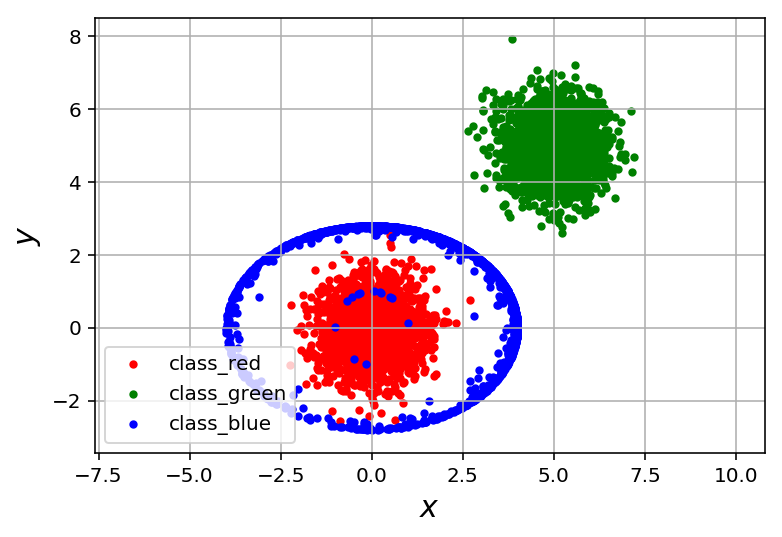

In [34]:
numOfSample = 2000
numOfTrain = 1500
numOfValidation = 250
(data1, label1, data2, label2, data3, label3) = create_data(numOfSample)
(train_X, train_Y, val_X, val_Y, test_X, test_Y) = devideDataset(data1, label1, data2, label2, data3, label3,
                                                                    numOfTrain, numOfValidation)
# Visualize dataset
%config InlineBackend.figure_format = 'retina'
visualize_data(data1, data2, data3, 1)

In [35]:
# Pre-process data
mean_X = np.mean(train_X, 0, keepdims=True)
std_X = np.std(train_X, 0, keepdims=True)
train_X = (train_X - mean_X) / std_X
val_X = (val_X - mean_X) / std_X
test_X = (test_X - mean_X) / std_X

# Set configuration
config = {}
config['demo_type'] = "classifynnsgd"
config['save_img'] = False
config['num_epoch'] = 1000
config['lr'] = 0.8
config['num_train_per_class'] = numOfTrain
config['num_hidden_node'] = 4
config['activation_function'] = 'relu'
config['display_rate'] = 10 # epochs per display time
config['momentum'] = 0.9


In [36]:
classification(train_X, train_Y, val_X, val_Y, test_X, test_Y, config)

Weight params:
[Iter 0] Train loss: 3.188622
[Iter 1] Train loss: 1.080358
[Iter 2] Train loss: 1.307300
[Iter 3] Train loss: 0.924692
[Iter 4] Train loss: 0.587484
[Iter 5] Train loss: 0.601433
[Iter 6] Train loss: 0.759400
[Iter 7] Train loss: 0.657361
[Iter 8] Train loss: 0.499608
[Iter 9] Train loss: 0.448768
[Iter 10] Train loss: 0.439799
[Iter 11] Train loss: 0.440384
[Iter 12] Train loss: 0.438540
[Iter 13] Train loss: 0.430272
[Iter 14] Train loss: 0.416143
[Iter 15] Train loss: 0.400319
[Iter 16] Train loss: 0.388153
[Iter 17] Train loss: 0.381535
[Iter 18] Train loss: 0.378318
[Iter 19] Train loss: 0.375440
[Iter 20] Train loss: 0.371569
[Iter 21] Train loss: 0.367086
[Iter 22] Train loss: 0.361895
[Iter 23] Train loss: 0.354883
[Iter 24] Train loss: 0.345387
[Iter 25] Train loss: 0.333542
[Iter 26] Train loss: 0.319363
[Iter 27] Train loss: 0.304688
[Iter 28] Train loss: 0.291131
[Iter 29] Train loss: 0.279839
[Iter 30] Train loss: 0.269751
[Iter 31] Train loss: 0.259181
[It

[Iter 285] Train loss: 0.101423
[Iter 286] Train loss: 0.101414
[Iter 287] Train loss: 0.101405
[Iter 288] Train loss: 0.101396
[Iter 289] Train loss: 0.101387
[Iter 290] Train loss: 0.101378
[Iter 291] Train loss: 0.101370
[Iter 292] Train loss: 0.101361
[Iter 293] Train loss: 0.101353
[Iter 294] Train loss: 0.101344
[Iter 295] Train loss: 0.101336
[Iter 296] Train loss: 0.101328
[Iter 297] Train loss: 0.101320
[Iter 298] Train loss: 0.101311
[Iter 299] Train loss: 0.101303
[Iter 300] Train loss: 0.101294
[Iter 301] Train loss: 0.101286
[Iter 302] Train loss: 0.101277
[Iter 303] Train loss: 0.101269
[Iter 304] Train loss: 0.101260
[Iter 305] Train loss: 0.101251
[Iter 306] Train loss: 0.101243
[Iter 307] Train loss: 0.101234
[Iter 308] Train loss: 0.101226
[Iter 309] Train loss: 0.101219
[Iter 310] Train loss: 0.101211
[Iter 311] Train loss: 0.101204
[Iter 312] Train loss: 0.101196
[Iter 313] Train loss: 0.101189
[Iter 314] Train loss: 0.101182
[Iter 315] Train loss: 0.101175
[Iter 31

[Iter 581] Train loss: 0.100563
[Iter 582] Train loss: 0.100563
[Iter 583] Train loss: 0.100563
[Iter 584] Train loss: 0.100562
[Iter 585] Train loss: 0.100562
[Iter 586] Train loss: 0.100562
[Iter 587] Train loss: 0.100560
[Iter 588] Train loss: 0.100558
[Iter 589] Train loss: 0.100555
[Iter 590] Train loss: 0.100552
[Iter 591] Train loss: 0.100549
[Iter 592] Train loss: 0.100547
[Iter 593] Train loss: 0.100544
[Iter 594] Train loss: 0.100538
[Iter 595] Train loss: 0.100532
[Iter 596] Train loss: 0.100527
[Iter 597] Train loss: 0.100522
[Iter 598] Train loss: 0.100518
[Iter 599] Train loss: 0.100515
[Iter 600] Train loss: 0.100512
[Iter 601] Train loss: 0.100510
[Iter 602] Train loss: 0.100507
[Iter 603] Train loss: 0.100505
[Iter 604] Train loss: 0.100503
[Iter 605] Train loss: 0.100500
[Iter 606] Train loss: 0.100498
[Iter 607] Train loss: 0.100497
[Iter 608] Train loss: 0.100495
[Iter 609] Train loss: 0.100494
[Iter 610] Train loss: 0.100493
[Iter 611] Train loss: 0.100492
[Iter 61

[Iter 877] Train loss: 0.100264
[Iter 878] Train loss: 0.100264
[Iter 879] Train loss: 0.100263
[Iter 880] Train loss: 0.100263
[Iter 881] Train loss: 0.100263
[Iter 882] Train loss: 0.100263
[Iter 883] Train loss: 0.100263
[Iter 884] Train loss: 0.100263
[Iter 885] Train loss: 0.100263
[Iter 886] Train loss: 0.100263
[Iter 887] Train loss: 0.100262
[Iter 888] Train loss: 0.100262
[Iter 889] Train loss: 0.100262
[Iter 890] Train loss: 0.100262
[Iter 891] Train loss: 0.100262
[Iter 892] Train loss: 0.100262
[Iter 893] Train loss: 0.100262
[Iter 894] Train loss: 0.100262
[Iter 895] Train loss: 0.100262
[Iter 896] Train loss: 0.100262
[Iter 897] Train loss: 0.100261
[Iter 898] Train loss: 0.100261
[Iter 899] Train loss: 0.100261
[Iter 900] Train loss: 0.100261
[Iter 901] Train loss: 0.100261
[Iter 902] Train loss: 0.100261
[Iter 903] Train loss: 0.100261
[Iter 904] Train loss: 0.100261
[Iter 905] Train loss: 0.100261
[Iter 906] Train loss: 0.100261
[Iter 907] Train loss: 0.100261
[Iter 90

## Kết quả phân nhóm